In [4]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score

from alibi_detect.od import IForest
from alibi_detect.datasets import fetch_kdd
from alibi_detect.utils.data import create_outlier_batch
from alibi_detect.utils.fetching import fetch_detector
from alibi_detect.utils.saving import save_detector, load_detector
from alibi_detect.utils.visualize import plot_instance_score, plot_roc

In [5]:
kddcup = fetch_kdd(percent10=True)

In [6]:
np.random.seed(0)
normal_batch = create_outlier_batch(kddcup.data, kddcup.target, n_samples=400000, perc_outlier=0)
X_train, y_train = normal_batch.data.astype('float'), normal_batch.target

In [7]:
mean, stdev = X_train.mean(axis=0), X_train.std(axis=0)
X_train = (X_train - mean) / stdev


In [8]:
od = IForest(threshold=None,  # threshold for outlier score
             n_estimators=100)

No threshold level set. Need to infer threshold using `infer_threshold`.


In [9]:
od.fit(X_train)
save_detector(od, '/content/')


Directory \content does not exist and is now created.


In [10]:
np.random.seed(0)
perc_outlier = 5
threshold_batch = create_outlier_batch(kddcup.data, kddcup.target, n_samples=1000, perc_outlier=perc_outlier)
X_threshold, y_threshold = threshold_batch.data.astype('float'), threshold_batch.target
X_threshold = (X_threshold - mean) / stdev
print('{}% outliers'.format(100 * y_threshold.mean()))

5.0% outliers


In [11]:
od.infer_threshold(X_threshold, threshold_perc=100-perc_outlier)
print('New threshold: {}'.format(od.threshold))

New threshold: 0.0797010793476482


In [12]:
np.random.seed(1)
outlier_batch = create_outlier_batch(kddcup.data, kddcup.target, n_samples=1000, perc_outlier=10)
X_outlier, y_outlier = outlier_batch.data.astype('float'), outlier_batch.target
X_outlier = (X_outlier - mean) / stdev
print(X_outlier.shape, y_outlier.shape)
print('{}% outliers'.format(100 * y_outlier.mean()))

(1000, 18) (1000,)
10.0% outliers


In [13]:
od_preds = od.predict(X_outlier, return_instance_score=True)


F1 score: 0.3279,
 Accuracy Score: 0.8770


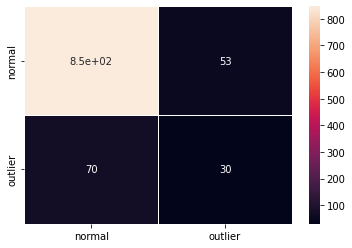

In [16]:
from sklearn.metrics import accuracy_score

labels = outlier_batch.target_names
y_pred = od_preds['data']['is_outlier']
f1 = f1_score(y_outlier, y_pred)
acc = accuracy_score(y_outlier, y_pred)
print('F1 score: {:.4f},\n Accuracy Score: {:.4f}'.format(f1, acc))
cm = confusion_matrix(y_outlier, y_pred)
df_cm = pd.DataFrame(cm, index=labels, columns=labels)
sns.heatmap(df_cm, annot=True, cbar=True, linewidths=.5)
plt.show()
